# Checking the GPU availability

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# GPUs Available:  1


In [35]:
import keras
tf.keras.__version__

'2.8.0'

# Loading the data 

In [3]:
# Import everything that will be used
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/aim/2_preprocessed_data.csv')
final_df = df[['preprocessed_text', 'dialect']]

In [7]:
length = []
sentences = []
for i in final_df.preprocessed_text:
    sentences.append(i.split())
    length.append(len(i))

In [8]:
print(len(sentences))
print(len(length))  # total no of sentences

453232
453232


i will try to guess the appropriate number of max words in a sentence

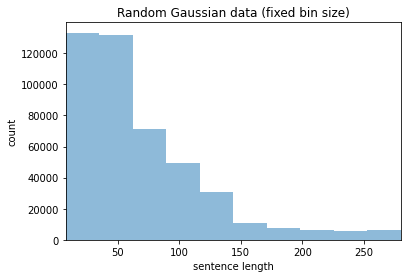

In [9]:

# fixed bin size
# bins = np.arange(-100, 100, 5) # fixed bin size

plt.xlim([min(length), max(length)])

plt.hist(length, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('sentence length')
plt.ylabel('count')

plt.show()

In [10]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec

In [11]:
import nltk

In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 300000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(final_df.preprocessed_text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 498575 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(final_df.preprocessed_text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (453232, 150)


In [14]:
Y = pd.get_dummies(final_df.dialect).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (453232, 18)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(407908, 150) (407908, 18)
(45324, 150) (45324, 18)


Here i tried using Bi-LSTM but found the simple LSTM is slightly better

In [19]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))

model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          30000000  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 150, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 18)                1818      
                                                                 
Total params: 30,082,218
Trainable params: 30,082,218
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
#saving the checkpoints
from keras.callbacks import ModelCheckpoint

# This checkpoint object will store the model parameters
# in the file "weights.hdf5"
checkpoint = ModelCheckpoint('/content/weights.hdf5', monitor='val_loss',
save_best_only=True)
# Store in a list to be used during training
callbacks_list = [checkpoint]
# Fit the model on a training set,


In [21]:
# now fitting the model
# the batch size = 400 by experimenting on the first epoch
epochs = 10
batch_size = 400
from keras.callbacks import EarlyStopping

with tf.device(device_name):
  history = model.fit(X_train, Y_train, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), checkpoint])

Epoch 1/10
918/918 [==============================] - 1020s 1s/step - loss: 1.9801 - accuracy: 0.3712 - val_loss: 1.5843 - val_accuracy: 0.5038
Epoch 2/10
918/918 [==============================] - 976s 1s/step - loss: 1.2817 - accuracy: 0.5985 - val_loss: 1.4782 - val_accuracy: 0.5466
Epoch 3/10
918/918 [==============================] - 994s 1s/step - loss: 0.8983 - accuracy: 0.7233 - val_loss: 1.5729 - val_accuracy: 0.5408
Epoch 4/10
918/918 [==============================] - 991s 1s/step - loss: 0.6597 - accuracy: 0.7979 - val_loss: 1.7400 - val_accuracy: 0.5326
Epoch 5/10
918/918 [==============================] - 969s 1s/step - loss: 0.5168 - accuracy: 0.8410 - val_loss: 1.9365 - val_accuracy: 0.5247


In [22]:
# evalute the model 
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1417/1417 [==============================] - 102s 72ms/step - loss: 1.9544 - accuracy: 0.5216
Test set
  Loss: 1.954
  Accuracy: 0.522


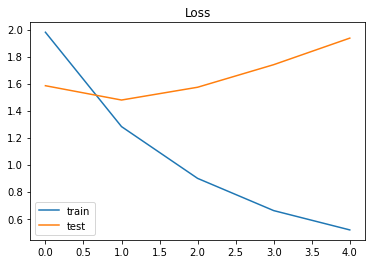

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

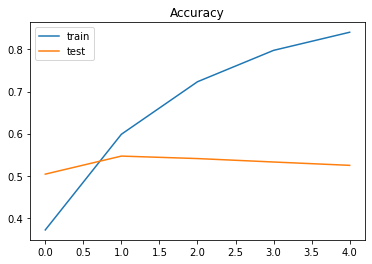

In [24]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [25]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
le= label_encoder.fit_transform(final_df['dialect'])
final_df['encoded'] = le

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Saving the model

In [28]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
import pickle

# saving
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(label_encoder,handle)

now let's test the model

In [48]:
def test(x):
  new_complaint = [x]
  seq = tokenizer.texts_to_sequences(new_complaint)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  # labels = target_encoded[1]
  # print(pred, labels[np.argmax(pred)])
  prediction = final_df[final_df['encoded'] == int(np.argmax(pred))]['dialect'].values[0]
  print(x, ': ', prediction)

test('ياسطا'), test('بزاف'), test('هلا فيك'), test('برشا'), test('زول'), test('مزيان')

ياسطا :  EG
بزاف :  DZ
هلا فيك :  KW
برشا :  TN
زول :  SD
مزيان :  MA


(None, None, None, None, None, None)

i think it works well tell now :)

# Last Thoughts

i think it works well because these the tested words are well known in their countries so the next step it to try testing the model on complete sentences and also on sentences that could be classified with more than one country by human

Salam 👋